In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import gmm_experiments_lib as gmm_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
import torch

In [4]:
np.random.seed(454)
_ = torch.manual_seed(454)

# Draw data

In [5]:
mu0 = torch.Tensor([0, 0])
sigma0 = 8
n_clusters = 10

n_obs = 200

In [6]:
gmm_experiment = gmm_lib.GMMExperiments(n_obs, mu0, sigma0, n_clusters, hidden_dim=200)

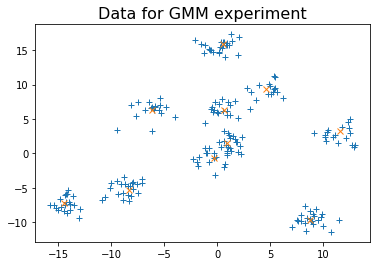

In [39]:
plt.plot(gmm_experiment.y[:, 0].numpy(), gmm_experiment.y[:, 1].numpy(), '+')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), gmm_experiment.true_mus[:, 1].numpy(), 'x')
plt.title('Data for GMM experiment', fontsize = 16)

plt.savefig('../../writing/AISTATS_results_figures/gmm_data.png')

# Set up marginalization class and run k-means init

In [8]:
gmm_experiment.set_kmeans_init_var_params()
# obj_class_reinforce.experiment_class.set_random_var_params()

k_means_init_params = deepcopy(gmm_experiment.var_params)

In [9]:
# check kmeans init
centroids_init = gmm_experiment.var_params['centroids']
class_weights = torch.exp(gmm_experiment.get_log_q().detach())

z_ind = np.argmax(class_weights.numpy(), axis = 1)

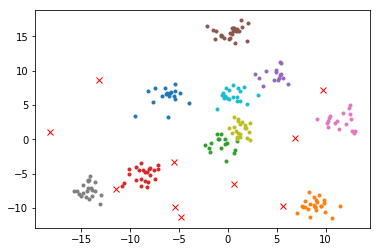

In [10]:
plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


# Train with true gradient

In [11]:
# vb_params_opt, loss_array_true_grad = obj_class_reinforce.run_SGD(alpha=0.0, topk = 1, lr = 1e-2, n_steps=1000, 
#                                                use_true_grad = True)

n_steps = 500
lr = 1e-2

loss_array_true_grad, opt_param = pm_lib.run_SGD(get_loss = gmm_experiment.get_full_loss, 
                params = gmm_experiment.var_params,
                lr = lr, 
                n_steps = n_steps)

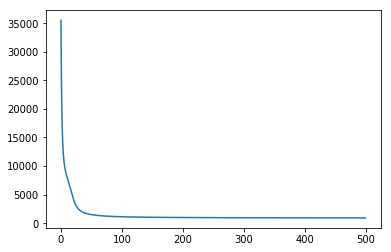

In [12]:
plt.plot(loss_array_true_grad)

In [13]:
print('initial elbo: ', loss_array_true_grad[0])

initial elbo:  35518.15234375


In [14]:
print('final elbo: ', loss_array_true_grad[-1])

final elbo:  917.8703002929688


In [15]:
class_weights_opt = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))
centroids_opt = opt_param['centroids']
sigma_opt = opt_param['log_sigma']

z_ind = torch.argmax(class_weights_opt, dim=1).numpy()

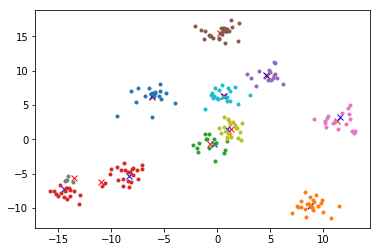

In [16]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

# Is REINFORCE useful at all here?

In [17]:
# Reuse same kmeans init
gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

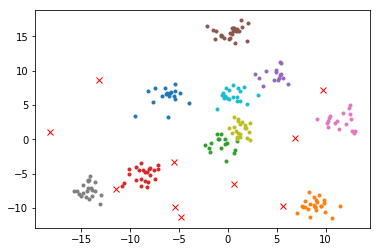

In [18]:
# # check kmeans init
centroids_init = gmm_experiment.var_params['centroids']
class_weights = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))

z_ind = np.argmax(class_weights.numpy(), axis = 1)

plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


In [19]:
class GMMLossClass(object): 
    def __init__(self, gmm_experiment, alpha, topk, use_baseline): 
        self.gmm_experiment = gmm_experiment
        self.alpha = alpha
        self.topk = topk
        self.use_baseline = use_baseline

    def get_loss(self): 
        return self.gmm_experiment.get_pm_loss(alpha=self.alpha, 
                                           topk=self.topk, 
                                           use_baseline=self.use_baseline)


In [20]:
gmm_loss_class = GMMLossClass(gmm_experiment, alpha = 0.0, topk = 0, use_baseline = True)

loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                get_loss = gmm_loss_class.get_loss, 
                params = gmm_experiment.var_params,
                lr = lr, 
                n_steps = n_steps, 
                get_full_loss = gmm_experiment.get_full_loss)

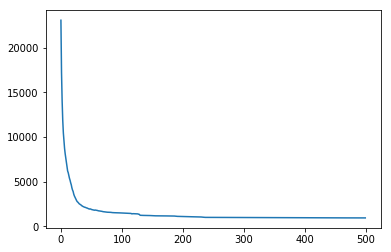

In [21]:
plt.plot(loss_array_reinforce_bl)

In [22]:
print('initial elbo: ', loss_array_reinforce_bl[0])

initial elbo:  23095.810546875


In [23]:
print('final elbo: ', loss_array_reinforce_bl[-1])

final elbo:  931.23974609375


In [24]:
class_weights_opt = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))
centroids_opt = opt_param['centroids']
sigma_opt = opt_param['log_sigma']

z_ind = torch.argmax(class_weights_opt, dim=1).numpy()

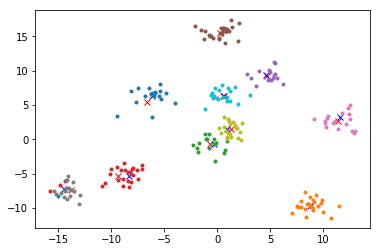

In [25]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

In [26]:
n_steps = 200
losses_array_all = np.zeros((n_clusters + 1, n_steps))

for i in range(n_clusters + 1): 
    gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

    gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
    gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

    print('topk: ', i)
    gmm_loss_class = GMMLossClass(gmm_experiment, alpha = 0.0, topk = i, use_baseline = True)

    loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                    get_loss = gmm_loss_class.get_loss, 
                    params = gmm_experiment.var_params,
                    lr = lr, 
                    n_steps = n_steps, 
                    get_full_loss = gmm_experiment.get_full_loss)
    
    losses_array_all[i, :] = loss_array_reinforce_bl
    
    print('initial elbo: ', loss_array_reinforce_bl[0])
    print('final elbo: ', loss_array_reinforce_bl[-1])

topk:  0
initial elbo:  22867.568359375
final elbo:  1415.7020263671875
topk:  1
initial elbo:  22765.41796875
final elbo:  1170.7005615234375
topk:  2
initial elbo:  22908.61328125
final elbo:  1199.8779296875
topk:  3
initial elbo:  22903.873046875
final elbo:  1095.36767578125
topk:  4
initial elbo:  23023.064453125
final elbo:  898.8333129882812
topk:  5
initial elbo:  23201.22265625
final elbo:  1119.689208984375
topk:  6
initial elbo:  23107.67578125
final elbo:  1061.3736572265625
topk:  7
initial elbo:  23278.048828125
final elbo:  875.8633422851562
topk:  8
initial elbo:  23191.544921875
final elbo:  916.1309814453125
topk:  9
initial elbo:  23055.0703125
final elbo:  925.6115112304688
topk:  10
initial elbo:  23198.779296875
final elbo:  889.4241333007812


In [27]:
losses_array_all.shape

(11, 200)

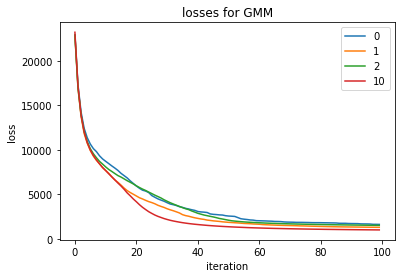

In [35]:
plt.plot(losses_array_all.T[0:100, np.array([0, 1, 2, 10])], '-')

plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('losses for GMM')

plt.legend(('0', '1', '2', '10'))


In [29]:
def get_avg_paths(gmm_experiment, k_means_init_params, n_summed, n_trials = 20, n_steps = 200, lr = 1): 
    # Function to run a few trials of SGD and get the average path 
    
    loss_path_all = np.zeros((n_trials, n_steps))
    
    for i in range(n_trials): 
        
        gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

        gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
        gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

        gmm_loss_class = GMMLossClass(gmm_experiment, alpha = 0.0, topk = n_summed, use_baseline = True)

        loss_array_reinforce_bl, opt_param = pm_lib.run_SGD(
                        get_loss = gmm_loss_class.get_loss, 
                        params = gmm_experiment.var_params,
                        lr = lr, 
                        n_steps = n_steps, 
                        get_full_loss = gmm_experiment.get_full_loss)

            
        loss_path_all[i, :] = loss_array_reinforce_bl
    
    loss_array_avg = np.mean(loss_path_all, axis = 0)
    
    return loss_array_avg, loss_path_all


0
1
2
3
10


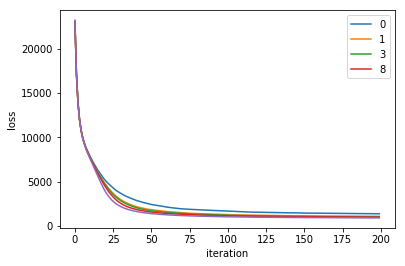

In [30]:
n_steps = 200

n_summed_array = [0, 1, 2, 3, 10]

avg_loss_num_reinforce_array = np.zeros((len(n_summed_array), n_steps))

for i in range(len(n_summed_array)): 
    n_summed = n_summed_array[i]
    print(n_summed)
    
    avg_loss_array, _ = \
        get_avg_paths(gmm_experiment, k_means_init_params, n_summed = n_summed, lr = lr, n_steps = n_steps)
        
    avg_loss_num_reinforce_array[i, :] = avg_loss_array
        
    plt.plot(avg_loss_array, '-')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend(('0', '1', '3', '8'))

# plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


In [31]:
avg_loss_num_reinforce_array.shape

(5, 200)

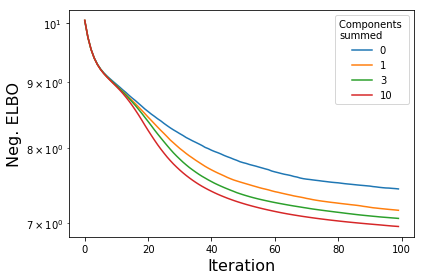

In [37]:
plt.semilogy(np.log(avg_loss_num_reinforce_array.T[0:100, [0, 1, 3, 4]]), '-')

plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Neg. ELBO', fontsize = 16)
# plt.title('losses for GMM', fontsize = 16)

plt.legend(('0', '1', '3', '10'), title = 'Components \nsummed')
plt.tight_layout()
save_fig = True
if save_fig: 
    plt.savefig('../../writing/AISTATS_results_figures/gmm_results.png')